Convolutions (or really, for PyTorch, *cross-correlations*) do not like edges. When thinking about the convolution of an image with a kernel as a sliding window, this operation is only valid when all pixels in the kernel completely cover a subregion of the image. In the context of difference imaging, this means that for a pair of equally sized reference and target images (and for any kernel larger than a single pixel) there will be some boundary part of the target image that has no associated model image. There are two straightforward compromises to this problem (i) use only the subset of pixels in the target image that have an associated model image, or (ii) use all available target image pixels, but artifically extend the reference image by 'padding'.

Option (i) rejects data (which is bad for very general reasons) but ensures all convolution computations are valid, while (ii) keeps all the data and preserves image dimensions, but isn't (mathematically) the 'correct' thing to do, and introduces an additional computational cost. But how different are the results of each approach in practice? And consequently, does it matter for the results of the experiments in this work? Further, how should one pad the reference image if option (ii) is chosen?

In both Alard & Lupton (1998) and Bramich (2008), it is noted that all pixels have the potential to enter the kernel solution. Indeed, as far as I can see the only rejected pixels are those associated with variable sources or issues with the detector. It is not until Bramich et al. (2013) that the point made above is first considered in Dan's papers. Across all the literature, I haven't seen an investigation into whether this 'matters' in practice for fiducial images and kernels. The pyDANDIA implementation of the Bramich (2008) algorithm opts for option (ii), so for the sake of comparing like-with-like in the paper, I guess we should similarly pad the reference image fed to PyTorchDIA. But how 'wrong' is this?

In the following, I'll difference an image against itself. The corresponding kernel should be exactly 1 at the centre, and 0 everywhere else. I'll approach this via both (i) and (ii), and see how the results differ.

In [1]:
# imports
import numpy as np
from scipy.signal import convolve2d
from astropy.io import fits
from MakeFakeImage import MakeFake
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import PyTorchDIA_CCD_NoPadding
import PyTorchDIA_CCD
import torch
torch.backends.cudnn.deterministic = True # ensure PyTorchDIA solution is reproducible

PyTorch version: 1.6.0
PyTorch version: 1.6.0


Max flux: 31887.373306543665
Frac for 142x142 image: 0.3336664210470882
Reference properties
Reference size: 142
Number of sources: 26
PSF standard deviation: 2.4014286128198323
Sky level: 734.6740023932911
F_max/F_total: 0.3336664210470882


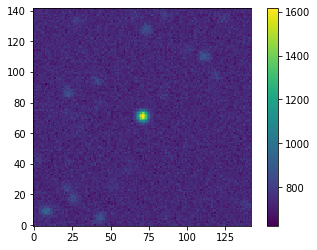

In [3]:
# generate a reference image
# set random seed for reproducibility
np.random.seed(42)
size = 142
log_density = np.random.uniform(0, 3, 1)[0]
star_density = 10**log_density # stars per 100x100 pixels
n_sources = np.int(star_density * (size**2/100**2))

reference_psf_sigma = np.random.uniform(0.5, 2.5, 1)[0] # this is ~ [1 - 6] fwhm
sky = np.random.uniform(10, 1000, 1)[0]
# positions
positions_x = np.random.uniform(0, size, (n_sources,1))
positions_y = np.random.uniform(0, size, (n_sources,1))
positions = np.hstack((positions_x, positions_y))

# fluxes
F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
fluxes = F**(-2./3.)
ref_clean, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                             psf_sigma=reference_psf_sigma, sky=sky,
                             positions=positions, fluxes=fluxes, shifts=[0., 0.])

print('Reference properties')
print('Reference size:', size)
print('Number of sources:', n_sources)
print('PSF standard deviation:', reference_psf_sigma)
print('Sky level:', sky)
print('F_max/F_total:', F_frac)

# and add some noise
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

R, sigma_R = add_noise_to_image(ref_clean, read_noise=5)

# and plot
plt.imshow(R, origin='lower')
plt.colorbar();

OK, let try approach (i) first. I'll fit for a 19x19 kernel. Consequently, I'll need to trim the data image to (142 - 19 + 1) = 124 pixels in each dimension.

In [4]:
kernel_size = 19
hwidth = np.int((kernel_size - 1) / 2)
nx, ny = R.shape
I = R[hwidth:nx-hwidth, hwidth:nx-hwidth]
I.shape

(124, 124)

--- Time to move data onto GPU: 1.9230625629425049 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 1931 SD steps
Converged!
Total steps taken: 1933
SD steps: 1931
L-BFGS steps: 2
--- Finished kernel and background fit in 3.226283311843872 seconds ---
Photometric scaling: tensor(1.0026197433, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.1434936523438


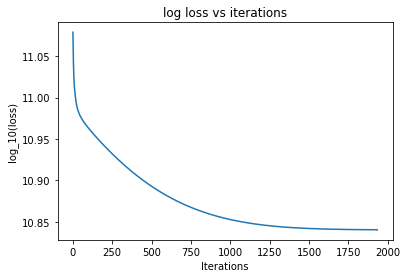

--- Finished in a total of 5.341187953948975 seconds ---


In [5]:
kernel_i, B0_ii = PyTorchDIA_CCD_NoPadding.DIA(R - sky,
                                           I,
                                           np.ones(I.shape), # flatfield
                                           rdnoise=5,
                                           G = 1,
                                           ks = kernel_size,
                                           lr_kernel = 1e-3,
                                           lr_B = 1,
                                           max_iterations = 25000,
                                           poly_degree=0,
                                           alpha = 0.,
                                           Newton_tol = 1e-6,
                                           tol = 1e-9,
                                           fast=True,
                                           fisher=False,
                                           show_convergence_plots=True)

And now for (ii), in which a zero-padding of (kernel_size - 1)/2 is applied around the boundary of R.

In [9]:
kernel_ii, B0_ii = PyTorchDIA_CCD.DIA(R - sky,
                                   R,
                                   np.ones(R.shape), # flatfield
                                   rdnoise=5,
                                   G = 1,
                                   ks = kernel_size,
                                   lr_kernel = 1e-3,
                                   lr_B = 1,
                                   max_iterations = 25000,
                                   poly_degree=0,
                                   alpha = 0.,
                                   Newton_tol = 1e-6,
                                   tol = 1e-9,
                                   fast=True,
                                   fisher=False,
                                   show_convergence_plots=False)

--- Time to move data onto GPU: 0.0002155303955078125 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 1917 SD steps
Converged!
Total steps taken: 1920
SD steps: 1917
L-BFGS steps: 3
--- Finished kernel and background fit in 3.755777359008789 seconds ---
Photometric scaling: tensor(1.0012421608, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.144287109375
--- Finished in a total of 3.762864828109741 seconds ---


OK, so even for these fairly small 142x142 images and a 19x19 kernel, the difference appears to be very small. The background parameters are effectively identical, and the photometric scale factor differs below the level at which it would influence the photometry (at the third decimal place). Of course, it is of note that neither approach actually returns a photometric scale of 1 at machine precision; this is due to the non-analytic nature of the optimisation, and the use of F32 precision for efficient convolution computations on the GPU. How do individual pixels/parameters differ in the kernels?

And finally, what if we use the same data as in (ii), but pad the reference frame?

In [10]:
R_cropped = R[hwidth:nx-hwidth, hwidth:nx-hwidth]
kernel_iii, B0_iii = PyTorchDIA_CCD.DIA(R_cropped - sky,
                                   I,
                                   np.ones(I.shape), # flatfield
                                   rdnoise=5,
                                   G = 1,
                                   ks = kernel_size,
                                   lr_kernel = 1e-3,
                                   lr_B = 1,
                                   max_iterations = 25000,
                                   poly_degree=0,
                                   alpha = 0.,
                                   Newton_tol = 1e-6,
                                   tol = 1e-9,
                                   fast=True,
                                   fisher=False,
                                   show_convergence_plots=False)

--- Time to move data onto GPU: 0.001360177993774414 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 1933 SD steps
Converged!
Total steps taken: 1937
SD steps: 1933
L-BFGS steps: 4
--- Finished kernel and background fit in 3.254138231277466 seconds ---
Photometric scaling: tensor(1.0008611679, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.1456298828125
--- Finished in a total of 3.2615787982940674 seconds ---


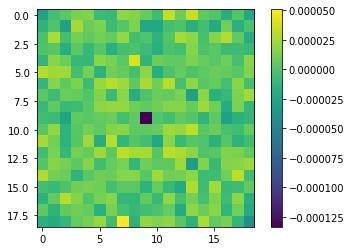

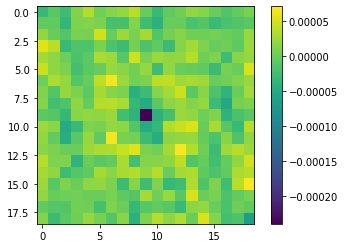

In [11]:
delta_kernel_ii = kernel_i - kernel_ii
plt.imshow(delta_kernel_ii)
plt.colorbar()
plt.show();

delta_kernel_iii = kernel_i - kernel_iii
plt.imshow(delta_kernel_iii)
plt.colorbar()
plt.show();

An important question for this work is if approaches (i) and (ii) would give signficantly different results for the fit quality and photometric accuracy metrics quoted for both the real and simulated images. We'll investigate that here.

In [12]:
## Specify all the functions required ##
## the B08 specific functions are once again adapted from pyDANDIA

# required for B08 approach to deal with edge pixels (convolutions don't like edges!)
def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# add gaussian noise to image under the standard CCD noise model
# N.B. Gain and flat-field are equal to 1, so we only include
# the readout noise [ADU] and the photon shot noise (in the gaussian limit)
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_imag = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_imag
    return image, sigma_imag

# adds 10 times **less** variance than add_noise_to_image
def add_less_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_imag = 10**(-0.5) * np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_imag
    return image, sigma_imag


# simply returns the model image
def model_image(R, kernel, B0):
    model = convolve2d(R, kernel, mode='same') + B0
    return model

# return the mean-squared-error (MSE) fit quality metric
def calc_MSE(M, I_noiseless, kernel_size):
    N_data = len(I_noiseless.flatten())
    MSE = 1./(N_data) * np.sum((M - I_noiseless)**2)
    return MSE

# returns the mean-fit-bias (MFB) and mean-fit-variance (MFV) fit quality metrics
def calc_MFB_and_MFV(M, I, noise_map, kernel_size):
    N_data = len(I.flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# plots the normalised residuals (epsilon) in D overlain with a unit gaussian
def plot_normalised_residuals(epsilon):
    plt.figure(figsize=(5,5))
    plt.hist(epsilon.flatten(), bins='auto', density=True)
    x = np.linspace(-5, 5, 100)
    plt.plot(x, norm.pdf(x, 0, 1))
    plt.xlim(-5, 5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Normalised residuals', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.show();

# plot a 2D numpy array    
def plot_image(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.colorbar()
    plt.show();

# returns the normalised_psf_object for the PSF fitting photometry
def normalised_psf_object(psf_sigma, psf_size, shifts):
    # first of, let's create the normalised PSF object to fit
    psf = np.zeros((psf_size, psf_size))
    nx, ny = psf_size, psf_size
    xg, yg = np.meshgrid(range(nx), range(ny))
    ## Let's extend this to 2 dimensions ##
    centre = np.int(nx/2)
    #pos = [centre, centre]
    pos = [centre + shifts[0], centre + shifts[1]]
    kernel = np.exp(-0.5 * ((xg - pos[0]) ** 2 + (yg - pos[1]) ** 2)/ psf_sigma ** 2)
    kernel /= np.sum(kernel) # normalise
    psf += kernel #/ (2. * np.pi * psf_sigma ** 2)
    return psf

# cutout around the central, brightest star
def cutout(image, c_size):
    centre = np.int(image.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    
    # Generate circular mask
    mask_stamp = np.random.normal(0, 3, size=(c_size, c_size))
    for row in mask_stamp:
        for pixel in row:
            coords = np.where(mask_stamp == pixel)
            y_coord, x_coord = coords[0][0], coords[1][0]
            centre_x, centre_y = np.int(cutout.shape[0]/2), np.int(cutout.shape[0]/2)
            delta_x = x_coord - centre_x
            delta_y = y_coord - centre_y
            distance = np.sqrt(delta_x**2 + delta_y**2)
            if distance < radius-1:
                mask_stamp[coords] = 0
            else:
                mask_stamp[coords] = 1
    
    # mask cutout
    #cutout = np.ma.array(cutout, mask=mask_stamp)
    
    return cutout

# results the PSF fitting photometry
def fit_results_and_resids(fit, psf, data):
    F_pred, const_pred = fit.x[0], fit.x[1]
    covmatrix = fit.hess_inv
    var = np.diag(covmatrix)
    print('\nPSF fit results:')
    print('F_pred:', F_pred, np.sqrt(var[0]))
    print('Additive constant:', const_pred, np.sqrt(var[1]))
    message = fit.message
    return F_pred, const_pred, message

# save a np.ndarray as .fits
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    
    
# compute log-likelihood of data given the (MLE) model
def evaluate_log_likelihood(data, model, var):
    #L(data|model_x) = - ( 1/2 * \chi^2 + \sum_{i=1}^{N} \ln \sigma_i + N/4 * \ln (2*\pi) ) ,)
    chi2 = (data - model)**2 / var
    lnsigma = 2 * np.log(var)
    norm_constant = (len(data) / 4) * np.log(2 * np.pi)
    return -np.sum(chi2 + lnsigma + norm_constant)



Simulation: 0
Generating reference...
Max flux: 3579.400409555033
Frac for 142x142 image: 0.19735953403829604
Reference properties
Reference size: 142
Number of sources: 11
PSF standard deviation: 0.5438610848707925
Sky level: 948.309639640074
F_max/F_total: 0.19735953403829604
Target kernel properties:
Kernel standard deviation: 0.7954971568282285
Kernel size: 19
shift_x, shift_y: [0.25583813] [0.04898265]
Max flux: 3579.400409555033
Frac for 142x142 image: 0.19735953403829604
Reference and target image shapes:
(142, 142) (142, 142)
Reference SNR: 12.940103201531107
Target SNR: 4.092019927447513
Sky subtracting reference.

Solution with padding
--- Time to move data onto GPU: 0.001771688461303711 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 301 SD

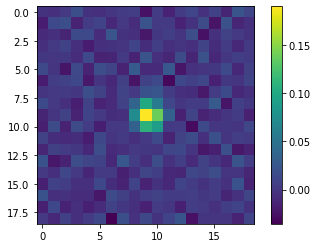


Photometric Scale Factor: 0.99460083
B_0: 948.5352172851562

Quality Metrics:
MSE 979.9583322204592
MFB -0.000408897969951927
MFV 1.0058319955711128


Log-likelihood: -1613395.3082946534
Converged
Fitted F_diff and const: Parameter containing:
tensor([206.8666839600], requires_grad=True) Parameter containing:
tensor([3.4808297157], requires_grad=True)
F_measured/sigma_min: [1.6461394]

Solution without padding
--- Time to move data onto GPU: 0.00020074844360351562 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 349 SD steps
Converged!
Total steps taken: 353
SD steps: 349
L-BFGS steps: 4
--- Finished kernel and background fit in 0.6080873012542725 seconds ---
Photometric scaling: tensor(1.0684820414, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 948.258

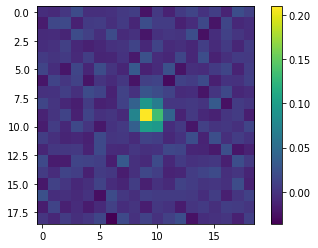


Photometric Scale Factor: 1.068482
B_0: 948.2587890625

Quality Metrics:
MSE 981.0844238221235
MFB 0.006587325121395224
MFV 1.0071000470503721


Log-likelihood: -1613417.0738197723
Converged
Fitted F_diff and const: Parameter containing:
tensor([141.3024902344], requires_grad=True) Parameter containing:
tensor([2.7053253651], requires_grad=True)
F_measured/sigma_min: [1.0466645]


Simulation: 1
Generating reference...
Max flux: 2203.0743905007894
Frac for 142x142 image: 0.39883723044543146
Reference properties
Reference size: 142
Number of sources: 3
PSF standard deviation: 0.5785710506607848
Sky level: 579.5768322895442
F_max/F_total: 0.39883723044543146
Target kernel properties:
Kernel standard deviation: 2.4363622954435153
Kernel size: 19
shift_x, shift_y: [-0.21992156] [0.08830052]
Max flux: 2203.0743905007894
Frac for 142x142 image: 0.39883723044543146
Reference and target image shapes:
(142, 142) (142, 142)
Reference SNR: 5.001738771114642
Target SNR: 1.5816886777893862
Sky subt

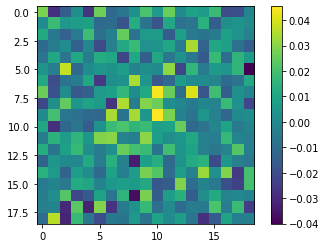


Photometric Scale Factor: 0.7389679
B_0: 579.4154052734375

Quality Metrics:
MSE 593.8146035943815
MFB -0.001430512755061436
MFV 0.9818644893163844


Log-likelihood: -1593681.156287212
Converged
Fitted F_diff and const: Parameter containing:
tensor([90.9711074829], requires_grad=True) Parameter containing:
tensor([1.8003412485], requires_grad=True)
F_measured/sigma_min: [0.5475151]

Solution without padding
--- Time to move data onto GPU: 0.0005095005035400391 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 101 SD steps


KeyboardInterrupt: 

In [13]:
torch.backends.cudnn.deterministic = True # ensure PyTorchDIA solution is reproducible

# number of simulations to run
n_simulations = 1000

# number of iterations to perform for each simulation
# for the first three iterations, we update the noise model
# used by the pyDANDIA solution. On the last i.e. 4th iteration
# we call the PyTorch code, which iterates 3 times automatically
n_iters = 2 # 4 normally!

for simulation in range(0, n_simulations):
    
    pad, no_pad = False, False
    print('\n\nSimulation:', simulation)
    # generate noiseless reference 'ref'
    print('Generating reference...')
    size = 142
    log_density = np.random.uniform(0, 3, 1)[0]
    star_density = 10**log_density # stars per 100x100 pixels
    n_sources = np.int(star_density * (size**2/100**2))       
    phi_r = np.random.uniform(0.5, 2.5, 1)[0] # in pixels, this is ~ [1 - 6] fwhm
    sky = np.random.uniform(10, 1000, 1)[0] # ADU
    
    # positions
    positions_x = np.random.uniform(0, size, (n_sources,1))
    positions_y = np.random.uniform(0, size, (n_sources,1))
    positions = np.hstack((positions_x, positions_y))

    # fluxes
    F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
    fluxes = F**(-2./3.)
    
    # Generate the noiseless reference image
    ref_noiseless, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                                     psf_sigma=phi_r, sky=sky,
                                     positions=positions, fluxes=fluxes, shifts=[0, 0])
    
    print('Reference properties')
    print('Reference size:', size)
    print('Number of sources:', n_sources)
    print('PSF standard deviation:', phi_r)
    print('Sky level:', sky)
    print('F_max/F_total:', F_frac) # flux ratio of brightest star that of all stars
    
    print('Target kernel properties:')
    phi_k = np.random.uniform(0.5, 2.5, 1)[0]
    kernel_size = 19
    kernel_size = (np.ceil(kernel_size) // 2 * 2 + 1).astype(int) # round up to nearest odd integer
    print('Kernel standard deviation:', phi_k)
    print('Kernel size:', kernel_size)

    # Generate the noiseless (and shifted) target image
    phi_i = np.sqrt(phi_k**2 + phi_r**2)
    
    # positions
    shift_x = np.random.uniform(-0.5, 0.5, 1)
    shift_y = np.random.uniform(-0.5, 0.5, 1)
    #shift_x, shift_y = 0, 0
    print('shift_x, shift_y:', shift_x, shift_y)
    positions_x_shifted = positions_x + shift_x
    positions_y_shifted = positions_y + shift_y
    positions_shifted = np.hstack((positions_x_shifted, positions_y_shifted))

    imag_noiseless, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                                     psf_sigma=phi_i, sky=sky,
                                     positions=positions_shifted, fluxes=fluxes,
                                     shifts = [shift_x[0], shift_y[0]])    
    

    imag_noiseless_copy = np.copy(imag_noiseless)
    ref_noiseless_copy = np.copy(ref_noiseless)
    
    # read noise [ADU]
    sigma_0 = 5.
    
    # add noise to the reference image
    ref, sigma_ref = add_less_noise_to_image(image=ref_noiseless, read_noise=sigma_0)
        
    # add noise to the target image i.e.
    imag, sigma_imag = add_noise_to_image(image=imag_noiseless, read_noise=sigma_0) # need noise map for PSF fitting later on
    
    print('Reference and target image shapes:')
    print(ref.shape, imag.shape)
    
    # calculate SNR of images
    SNR_ref = np.sum(ref_noiseless_copy - sky) / np.sqrt(np.sum(sigma_ref**2))
    SNR_imag = np.sum(imag_noiseless_copy - sky) / np.sqrt(np.sum(sigma_imag**2))
    print('Reference SNR:', SNR_ref)
    print('Target SNR:', SNR_imag)
    
    # plot the image pair
    '''
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(ref)
    axarr[0].set_title('Reference Image')
    axarr[1].imshow(imag)
    axarr[1].set_title('Target Image')
    plt.show();
    '''
    
    # exit if SNR_imag > 1000
    if SNR_imag > 1000:
        print('Target SNR regime out of bounds! Skipping...')
        continue
    
    # 'sky' subtract reference... **crucial** for getting past
    # the strong anticorrelation between P and B0
    print("Sky subtracting reference.")
    #ref -= np.median(ref)
    ref -= sky

    for i in range(0, n_iters):
               
        if i == 0:

            print('\nSolution with padding')
            pad = True
            kernel, B0 = PyTorchDIA_CCD.DIA(ref,
                                       imag,
                                       np.ones(imag.shape), # flatfield
                                       rdnoise=sigma_0,
                                       G = 1,
                                       ks = kernel_size,
                                       lr_kernel = 1e-3,
                                       lr_B = 10,
                                       max_iterations = 25000,
                                       poly_degree=0,
                                       alpha = 0.,
                                       Newton_tol = 1e-6,
                                       tol = 1e-9,
                                       fast=True,
                                       fisher=False,
                                       show_convergence_plots=False)
            
            
        else:
            
            print('\nSolution without padding')
            pad = False
            no_pad = True
            SD_steps = 25000
            
            hwidth = np.int((kernel_size - 1) / 2)
            nx, ny = ref.shape
            imag_cropped = imag[hwidth:nx-hwidth, hwidth:nx-hwidth]
            
            kernel, B0 = PyTorchDIA_CCD_NoPadding.DIA(ref,
                                       imag_cropped,
                                       np.ones(imag_cropped.shape), # flatfield
                                       rdnoise=sigma_0,
                                       G = 1,
                                       ks = kernel_size,
                                       lr_kernel = 1e-3,
                                       lr_B = 10,
                                       max_iterations = 25000,
                                       poly_degree=0,
                                       alpha = 0.,
                                       Newton_tol = 1e-6,
                                       tol = 1e-9,
                                       fast=True,
                                       fisher=False,
                                       show_convergence_plots=False)
            
            

      
        plt.imshow(kernel)
        plt.colorbar()
        plt.show();
        
        
        ## compute model image ##
        ## N.B. we extend the border of ref to handle edge-effects associated with the convolution
        ext_ref = extend_image(ref, kernel_size)
        ext_M = model_image(ext_ref, kernel, B0)
        M = ext_M[kernel_size:ext_M.shape[0]-kernel_size, kernel_size:ext_M.shape[1]-kernel_size]
                
        
        ## on the final iteration only, compute fit metrics,
        ## and perform PSF fitting photometry
        ## at the position of the brightest star
        if pad == True or no_pad == True:
            
            # print best fit parameters
            print('\nPhotometric Scale Factor:', np.sum(kernel))
            print('B_0:', B0)


            # Fit quality metrics
            MSE = calc_MSE(M, imag_noiseless, kernel_size)
            MFB, MFV = calc_MFB_and_MFV(M, imag, sigma_imag, kernel_size)
            #MSEs, MFBs, MFVs = np.append(MSEs, MSE), np.append(MFBs, MFB), np.append(MFVs, MFV)
            print('\nQuality Metrics:')
            print('MSE', MSE)
            print('MFB', MFB)
            print('MFV', MFV)
            print('\n')

            # compute the difference image / fit residuals and inferred pixel_variances
            D = imag - M
            
            
            # inspect normalised residuals against a unit gaussian
            pixel_variances = sigma_0**2 + M # G=1, F_ij=1
            
            # evaluate the log-likelihood of the data under the (MLE) model
            ll = evaluate_log_likelihood(imag, M, pixel_variances)
            print('Log-likelihood:', ll)
            
            ## PSF fitting photometry of brightest, central star ##
            stamp_size = phi_i * 9 # i.e. about 4*target_FWHM
            stamp_size = (np.ceil(stamp_size) // 2 * 2 + 1).astype(int) # round up to nearest odd integer
            
            psf_object = normalised_psf_object(phi_r, stamp_size, [0., 0.])
            true_target_psf_object = normalised_psf_object(phi_i, stamp_size, [shift_x[0], shift_y[0]])

            # convolve normalised psf_object with the kernel and re-normalise
            # remember to deal with the borders appropriately!
            ext_psf_object = extend_image(psf_object, kernel_size)
            ext_target_psf_object = convolve2d(ext_psf_object, kernel, mode='same')
            target_psf_object = ext_target_psf_object[kernel_size:ext_target_psf_object.shape[0]-kernel_size,
                                                      kernel_size:ext_target_psf_object.shape[1]-kernel_size]
            
            target_psf_object = target_psf_object / np.sum(target_psf_object)
            
            # make stamp around position of bright star in D
            stamp = cutout(D, stamp_size)

            # cutout target image pixel noise to weight the fit
            noise_stamp = cutout(sigma_imag, stamp_size)

            # initialise fit parameters: the difference flux and additive constant
            F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
            const = torch.nn.Parameter(torch.ones(1), requires_grad=True)

            # convert numpy.ndarray to torch.Tensor
            target_psf_object = torch.from_numpy(target_psf_object)
            stamp = torch.from_numpy(stamp)
            noise_stamp = torch.from_numpy(noise_stamp)
            
            # chi-square likelihood, as pixel variances known a priori
            class log_likelihood(torch.nn.Module):
                def forward(model, stamp, noise_stamp):
                    loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()
                    return -loglikelihood
            
            # initialise optimizer
            optimizer = torch.optim.Adam([F_diff, const], lr=10)

            tol = 1e-9
            losses = []
            F_diffs = []
            
            # optimally scale F_diff to the target_psf_object
            for i in range(0, 1000000):
                optimizer.zero_grad()
                model = F_diff*target_psf_object + const
                F_diffs.append(F_diff.item())
                loss = log_likelihood.forward(model, stamp, noise_stamp)
                losses.append(loss.item())
                loss.backward()
                optimizer.step()
                
                if i>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                    print('Converged')
                    break
                

            print('Fitted F_diff and const:', F_diff, const)
             
            ## convert tensors back to numpy arrays
            F_diff = F_diff.detach().numpy()
            const = const.detach().numpy()
            target_psf_object = target_psf_object.detach().numpy()
            stamp = stamp.detach().numpy()
            noise_stamp = noise_stamp.detach().numpy()
            
            ## compute normalised residuals
            prediction = F_diff*target_psf_object + const
            residuals_stamp = (prediction - stamp) / noise_stamp
            
            ## inspect images as .fits
            #save_numpy_as_fits(D/np.sqrt(pixel_variances), 'residuals_D.fits')
            #save_numpy_as_fits(stamp, 'stamp.fits')
            #save_numpy_as_fits(cutout(imag, stamp_size), 'imag_stamp.fits')
            #save_numpy_as_fits(target_psf_object, 'target_psf_object.fits')
            #save_numpy_as_fits(true_target_psf_object, 'true_target_psf_object.fits')
            #save_numpy_as_fits(residuals_stamp, 'residuals_stamp.fits')
            

            ## Compute F_measured of brightest star
            F_measured = F_diff / np.sum(kernel)

            # Compute the theoretical minimum variance for F_measured
            P_true = 1.
            var_min = (1./P_true**2) * (np.sum((true_target_psf_object**2)/(noise_stamp**2)))**(-1)
            print('F_measured/sigma_min:', F_measured/np.sqrt(var_min))
            
            out = np.vstack((np.sum(kernel), B0, MSE, MFB, MFV, F_measured, var_min,
                            star_density, phi_r, sky, phi_k,
                            SNR_ref, SNR_imag, F_frac, shift_x, shift_y, ll))
            
            #path = '/media/james/Seagate_Expansion_Drive#2'
            path = os.getcwd()
            
            if pad == True:
                filename = os.path.join(path, 'PyTorch_Pad.txt')
                with open(filename, 'a') as f:
                    np.savetxt(f, out.T)
            elif no_pad == True:
                filename = os.path.join(path, 'PyTorch_NoPad.txt')
                with open(filename, 'a') as f:
                    np.savetxt(f, out.T)  